## Summary

```bash
NOTEBOOK_PATH="$(realpath 31_cagi6_sherloc_el2.ipynb)" ORIGINAL_ARRAY_TASK_COUNT=421 sbatch --array=1-180 --gres=gpu:t4:1 ../scripts/run_notebook_gpu.sh

NOTEBOOK_PATH="$(realpath 31_cagi6_sherloc_el2.ipynb)" ORIGINAL_ARRAY_TASK_COUNT=421 sbatch --array=181-200 --gres=gpu:v100:1 ../scripts/run_notebook_gpu.sh

NOTEBOOK_PATH="$(realpath 31_cagi6_sherloc_el2.ipynb)" ORIGINAL_ARRAY_TASK_COUNT=421 sbatch --array=201-306 ../scripts/run_notebook_cpu.sh
```

---

## Imports

In [1]:
import os
import socket
import tempfile
from pathlib import Path

import elaspic2 as el2
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import torch
from tqdm.auto import tqdm

## Parameters

In [2]:
NOTEBOOK_DIR = Path("31_cagi6_sherloc_el2").resolve()
NOTEBOOK_DIR.mkdir(exist_ok=True)

NOTEBOOK_DIR

PosixPath('/project/6008029/strokach/workspace/elaspic2-cagi6/notebooks/31_cagi6_sherloc_el2')

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [4]:
# if "DATAPKG_OUTPUT_DIR" in os.environ:
#     OUTPUT_DIR = Path(os.getenv("DATAPKG_OUTPUT_DIR")).joinpath("elaspic2").resolve()
# else:
OUTPUT_DIR = NOTEBOOK_DIR.parent
OUTPUT_DIR.mkdir(exist_ok=True)

OUTPUT_DIR

PosixPath('/project/6008029/strokach/workspace/elaspic2-cagi6/notebooks')

In [5]:
if (slurm_tmpdir := os.getenv("SLURM_TMPDIR")) is not None:
    os.environ["TMPDIR"] = slurm_tmpdir
    
print(tempfile.gettempdir())

/tmp


In [6]:
if "scinet" in socket.gethostname():
    CPU_COUNT = 40
else:
    CPU_COUNT = max(1, len(os.sched_getaffinity(0)))

# CPU_COUNT = max(1, CPU_COUNT // 2)

CPU_COUNT

8

In [7]:
TASK_ID = os.getenv("SLURM_ARRAY_TASK_ID")
TASK_COUNT = os.getenv("ORIGINAL_ARRAY_TASK_COUNT") or os.getenv("SLURM_ARRAY_TASK_COUNT")
SUBTASK_ID = os.getenv("SUBTASK_ID")
SUBTASK_COUNT = os.getenv("SUBTASK_COUNT")

TASK_ID = int(TASK_ID) if TASK_ID is not None else None
TASK_COUNT = int(TASK_COUNT) if TASK_COUNT is not None else None
SUBTASK_ID = int(SUBTASK_ID) if SUBTASK_ID is not None else None
SUBTASK_COUNT = int(SUBTASK_COUNT) if SUBTASK_COUNT is not None else None

TASK_ID, TASK_COUNT

(None, None)

In [8]:
DEBUG = TASK_ID is None

if DEBUG:
    TASK_ID = 201
    TASK_COUNT = 421
else:
    assert TASK_ID is not None
    assert TASK_COUNT is not None

TASK_ID, TASK_COUNT

(201, 421)

## Load input data

In [9]:
input_file = NOTEBOOK_DIR.parent.joinpath("30_cagi6_sherloc", "processed-input-data.parquet")

full_input_df = pq.read_table(input_file).to_pandas()

In [10]:
full_input_df["sequence_length"] = full_input_df["sequence"].str.len().values
full_input_df = full_input_df.sort_values("sequence_length", ascending=True)
del full_input_df["sequence_length"]

In [11]:
full_input_df.head(2)

,uniprot_id,hgvs,mut,interpretation,sequence,structure
755,P26678,"[NM_002667.3:c.22A>C, NM_002667.3:c.25C>T, NM_...","[T8P, R9C, R9H, S10L, I12V, I12M, R14I, I18T, ...","[Uncertain significance, Pathogenic, Likely pa...",MEKVQYLTRSAIRRASTIEMPQQARQKLQNLFINFCLILICLLLIC...,HEADER ...
1239,Q00LT1,"[NM_001077620.2:c.13C>G, NM_001077620.2:c.50G>...","[L5V, R17H, R18Q, F19I, R22Q, P25L, D29N, D29H...","[Uncertain significance, Uncertain significanc...",MCTTLFLLSTLAMLWRRRFANRVQPEPSDVDGAARGSSLDADPQSS...,HEADER ...


## Select chunk in question

In [12]:
num_mutations = full_input_df["hgvs"].apply(len).sum()

num_mutations

194514

In [13]:
chunk_size = num_mutations // TASK_COUNT + 1

chunk_size

463

In [14]:
chunk_idx = TASK_ID - 1

chunk_idx

200

In [15]:
def select_chunk(full_input_df, chunk_size, chunk_idx):
    chunk_sizes = []
    chunk_uniprot_ids = []

    is_finished = False
    iterator = full_input_df.itertuples()
    while not is_finished:
        current_size = 0
        while current_size < chunk_size:
            try:
                tup = next(iterator)
            except StopIteration:
                is_finished = True
                break
            current_size += len(tup.hgvs)
            if len(chunk_sizes) == chunk_idx:
                chunk_uniprot_ids.append(tup.uniprot_id)
        chunk_sizes.append(current_size)
    return chunk_uniprot_ids, chunk_sizes

In [16]:
chunk_uniprot_ids, chunk_sizes = select_chunk(full_input_df, chunk_size, chunk_idx)

In [17]:
actual_task_count = len(chunk_sizes)

actual_task_count

306

306


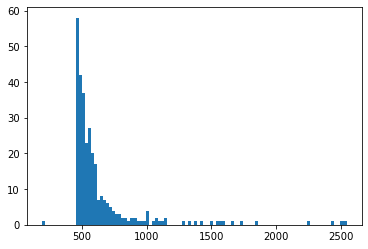

In [18]:
if DEBUG:
    import matplotlib.pyplot as plt
    plt.hist(chunk_sizes, bins=100)
    print(len(chunk_sizes))

In [19]:
input_df = full_input_df[full_input_df["uniprot_id"].isin(chunk_uniprot_ids)]

In [20]:
display(input_df.head(2))
print(len(input_df))
print(sum(input_df["hgvs"].apply(len)))

,uniprot_id,hgvs,mut,interpretation,sequence,structure
2364,Q9NSE4,"[NM_018060.3:c.137C>T, NM_018060.3:c.1564A>G, ...","[S46F, I522V, Y648C, E1007Q, A136T, Q431R, G62...","[Likely benign, Benign, Benign, Likely benign,...",MRWGLRPRGPGAAALATARSLWGTPRLPCSPGWQGATKRLLVRSVS...,HEADER ...
582,P13637,"[NM_152296.4:c.3014G>A, NM_152296.4:c.3011G>T,...","[G1005D, G1004V, G1004A, P1003L, R1000C, D992H...","[Uncertain significance, Uncertain significanc...",MGDKKDDKDSPKKNKGKERRDLDDLKKEVAMTEHKMSVEEVCRKYN...,HEADER ...


5
850


## Run `ELASPIC2`

### Initialize the `ELASPIC2` model



In [21]:
model = el2.ELASPIC2(device=device)

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator PCA from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
Some weights of the model checkpoint at /project/6008029/strokach/workspace/elaspic2/src/elaspic2/plugins/protbert/data/prot_bert_bfd were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if y

### Make predictions

In [22]:
if DEBUG:
    input_df = input_df.iloc[:2]

In [23]:
results = []
for tup in input_df.itertuples():
    with tempfile.NamedTemporaryFile(suffix=".pdb") as tmp_file:
        with open(tmp_file.name, "wt") as fout:
            fout.write(tup.structure)
        protein_features = model.build(
            structure_file=tmp_file.name,
            protein_sequence=tup.sequence,
            ligand_sequence=None,
            remove_hetatms=True,
        )

    mutation_features = list(
        tqdm(
            (model.analyze_mutation(mut, protein_features) for mut in tup.mut),
            total=len(tup.mut),
        )
    )

    row = {
        "uniprot_id": tup.uniprot_id,
        "protbert_score": [
            f["protbert_core_score_wt"] - f["protbert_core_score_mut"] for f in mutation_features
        ],
        "proteinsolver_score": [
            f["proteinsolver_core_score_wt"] - f["proteinsolver_core_score_mut"]
            for f in mutation_features
        ],
        "el2_score": model.predict_mutation_effect(mutation_features).tolist(),
        **{name: [f[name] for f in mutation_features] for name in mutation_features[0]},
    }
    results.append(row)

In [24]:
results_df = pd.DataFrame(results)

results_df.head()

,uniprot_id,protbert_score,proteinsolver_score,el2_score,protbert_core_score_wt,protbert_core_score_mut,protbert_core_features_residue_wt,protbert_core_features_protein_wt,protbert_core_features_residue_mut,protbert_core_features_protein_mut,proteinsolver_core_score_wt,proteinsolver_core_score_mut
0,Q9NSE4,"[0.2429826445877552, 0.6601177379488945, 0.860...","[0.12946259044110775, 0.4209132716059685, 0.07...","[1.16909026168563, 1.0394838876264054, 3.10654...","[0.2738088071346283, 0.7801834344863892, 0.860...","[0.030826162546873093, 0.12006569653749466, 3....","[[0.01616564206779003, 0.02875034511089325, -0...","[[0.00690156314522028, 0.009724152274429798, -...","[[0.09152738004922867, 0.048300810158252716, -...","[[0.007011280860751867, 0.011212294921278954, ...","[0.13998274505138397, 0.48017174005508423, 0.0...","[0.010520154610276222, 0.05925846844911575, 0...."
1,P13637,"[0.7124136320780963, 0.2215306640136987, 0.156...","[0.6868957187980413, 0.32814047392457724, 0.31...","[1.45919294372345, 1.0694967924618553, 0.16923...","[0.7161187529563904, 0.22379623353481293, 0.22...","[0.0037051208782941103, 0.00226556952111423, 0...","[[0.0465807244181633, -0.08027972280979156, -0...","[[0.027783889323472977, -0.029638268053531647,...","[[0.028527941554784775, -0.018569590523838997,...","[[0.027689816430211067, -0.029414359480142593,...","[0.7100364565849304, 0.3435646593570709, 0.343...","[0.023140737786889076, 0.015424185432493687, 0..."


## Write results

In [31]:
output_df = input_df[["uniprot_id", "hgvs", "mut"]].merge(results_df, on=["uniprot_id"], how="left")

output_df.head(2)

,uniprot_id,hgvs,mut,protbert_score,proteinsolver_score,el2_score,protbert_core_score_wt,protbert_core_score_mut,protbert_core_features_residue_wt,protbert_core_features_protein_wt,protbert_core_features_residue_mut,protbert_core_features_protein_mut,proteinsolver_core_score_wt,proteinsolver_core_score_mut
0,Q9NSE4,"[NM_018060.3:c.137C>T, NM_018060.3:c.1564A>G, ...","[S46F, I522V, Y648C, E1007Q, A136T, Q431R, G62...","[0.2429826445877552, 0.6601177379488945, 0.860...","[0.12946259044110775, 0.4209132716059685, 0.07...","[1.16909026168563, 1.0394838876264054, 3.10654...","[0.2738088071346283, 0.7801834344863892, 0.860...","[0.030826162546873093, 0.12006569653749466, 3....","[[0.01616564206779003, 0.02875034511089325, -0...","[[0.00690156314522028, 0.009724152274429798, -...","[[0.09152738004922867, 0.048300810158252716, -...","[[0.007011280860751867, 0.011212294921278954, ...","[0.13998274505138397, 0.48017174005508423, 0.0...","[0.010520154610276222, 0.05925846844911575, 0...."
1,P13637,"[NM_152296.4:c.3014G>A, NM_152296.4:c.3011G>T,...","[G1005D, G1004V, G1004A, P1003L, R1000C, D992H...","[0.7124136320780963, 0.2215306640136987, 0.156...","[0.6868957187980413, 0.32814047392457724, 0.31...","[1.45919294372345, 1.0694967924618553, 0.16923...","[0.7161187529563904, 0.22379623353481293, 0.22...","[0.0037051208782941103, 0.00226556952111423, 0...","[[0.0465807244181633, -0.08027972280979156, -0...","[[0.027783889323472977, -0.029638268053531647,...","[[0.028527941554784775, -0.018569590523838997,...","[[0.027689816430211067, -0.029414359480142593,...","[0.7100364565849304, 0.3435646593570709, 0.343...","[0.023140737786889076, 0.015424185432493687, 0..."


In [32]:
output_file = NOTEBOOK_DIR.joinpath(f"output-{TASK_ID}-of-{actual_task_count}.parquet")

output_file

PosixPath('/project/6008029/strokach/workspace/elaspic2-cagi6/notebooks/31_cagi6_sherloc_el2/output-201-of-306.parquet')

In [33]:
if not DEBUG:
    pq.write_table(pa.Table.from_pandas(output_df, preserve_index=False), output_file)

In [35]:
print("Done!")

Done!
